# CIFAR10 : CNN Example

In [ ]:
!pip install torchinfo

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torchvision  import models
from   torchinfo    import summary  

## MNIST dataset

In [7]:
from torchvision import datasets
from torchvision.transforms import ToTensor 
trn_data = datasets.CIFAR10(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
tst_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

Files already downloaded and verified


trn: (50000, 32, 32, 3) 50000
tst: (10000, 32, 32, 3) 10000


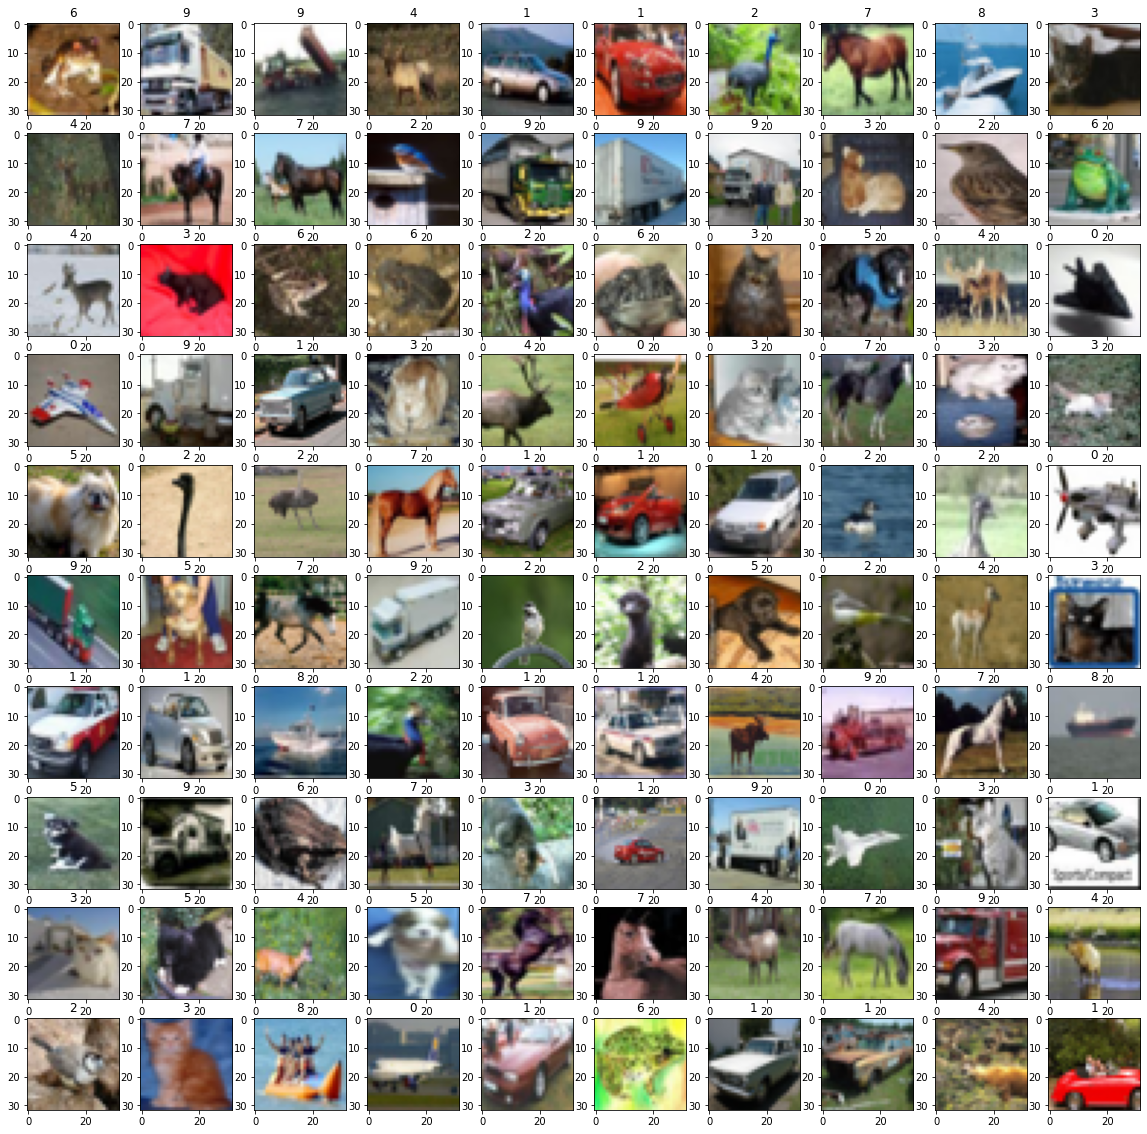

TypeError: data type not understood

In [20]:
print("trn:", trn_data.data.shape, len(trn_data.targets))
print("tst:", tst_data.data.shape, len(tst_data.targets))

IMAGE_SIZE  = (32,32)
NUM_CLASSES = 10

plt.figure(figsize=(20, 20), facecolor ='w')                  
for i in range(100):    
    ax=plt.subplot(10, 10, i+1)    
    img = trn_data.data[i]
    y   = trn_data.targets[i]
    plt.title(f"{y}")
    
    plt.imshow(img)  # inverse !!!
    #ax.set_xticks(np.linspace(0, IMAGE_SIZE[0], 5 ))
    #ax.set_yticks(np.linspace(0, IMAGE_SIZE[1], 5 ))
    #ax.grid(color='lightgray', linestyle='--', alpha=0.6)    
plt.show()    

X_trn, Y_trn = trn_data.data.view((-1, 1) + IMAGE_SIZE).float()/255,   trn_data.targets
X_tst, Y_tst = tst_data.data.view((-1, 1) + IMAGE_SIZE).float()/255,   tst_data.targets

## Model

After the stack of cnn-layers, there is a fully connected layer with the number of outputs equal to the number of classes.<br> The dimension of its input is calculated in the constructor (`w`, `h`).

In [17]:
class CNN(nn.Module):
    def __init__(self, 
                 shape   = (1, 64, 64),                                              # Input image shape (channels, height, width)        
                 outputs = 1,                                                        # Number of outpust 
                 channels = [], conv_kernels=[], conv_stride=1,  paddings=1, mode='replicate',      # Conv2d
                 batchnorm=False,                                                    # batchnorm
                 pool_kernel=2, pool_stride=2,  pool="max",         # Pooling
                 dropout=0.2,                                                        # Dropout
                 hiddens=None):                                                      # Add output hidden layers
        super(CNN, self).__init__()

        if paddings          == None: paddings    = 0                            # default
        if type(paddings)    == int:  paddings    = [paddings]   *len(channels)
        if conv_stride       == None: conv_stride = 1                            # default
        if type(conv_stride) == int:  conv_stride = [conv_stride]*len(channels)
        if pool_kernel       == None: pool_kernel = 2                            # default
        if type(pool_kernel) == int:  pool_kernel = [pool_kernel]*len(channels)    
        if type(pool_stride) == int:  pool_stride = [pool_stride]*len(channels)
        if not hiddens:               hiddens = []

        in_channels, h, w = shape                                                      
        channels = [in_channels] + channels
        self.layers = []
        for i in range(len(channels)-1):
            if conv_kernels[i]:
                self.layers +=  [ 
                    nn.Conv2d(channels[i], channels[i+1], kernel_size=conv_kernels[i], stride=conv_stride[i],  padding=paddings[i], padding_mode=mode),
                ]
                if batchnorm:                          # beetwen Line and non line   http://arxiv.org/pdf/1502.03167v2.pdf
                    self.layers += [ nn.BatchNorm2d(num_features=channels[i+1]) ]
                self.layers += [ nn.ReLU() ]             

                h = int( (h + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)
                w = int( (w + 2*paddings[i] - conv_kernels[i]) / conv_stride[i] + 1)  

            print("1:", w)

            if pool_kernel[i] > 1:
                if pool == 'max': self.layers += [nn.MaxPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                else:             self.layers += [nn.AvgPool2d(kernel_size=pool_kernel[i], stride=pool_stride[i]) ]
                h = int( (h - pool_kernel[i]) / pool_stride[i] + 1)
                w = int( (w - pool_kernel[i]) / pool_stride[i] + 1)

            print("2:", w)
                
        self.layers += [ nn.Flatten(1) ]

        hiddens = [channels[-1] * h * w] + hiddens + [outputs]
        for i in range( len(hiddens)-1):
            if dropout > 0:        
                self.layers += [ nn.Dropout(p=dropout) ]
        
            self.layers += [ nn.Linear(hiddens[i], hiddens[i+1] ) ]
            if i < len(hiddens)-2:                              # for probability after this need sigmoid (we used BCEWithLogitsLoss)
                self.layers += [ nn.ReLU() ]

        self.model = nn.Sequential(*self.layers)                 
 
    def forward(self, x):               
        return self.model(x)

    def get(self, x):
        res = []
        for layer in self.layers:
            x = layer(x)
            res.append(x.data.cpu().numpy())
        return res

In [29]:
CFG = {
    'input':     (1,)+IMAGE_SIZE,
    'outputs':   NUM_CLASSES,
    
    'channels':  [16,32],
    'kernels':   [5,3],
    'strides':   [1,1],
    'paddings':  [2,1],
    'mode':      'replicate',   #'replicate', 'zeros'
    'pool_ker':  [2,2],
    'pool_str':  [2,2],
    'batchnorm': False,
    'dropout':   0.,
    'batch':     512,
    'lr':        5e-4,   #!!!
    'L2':        1e-2,
    'hiddens':  []       #!!!
} 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN(shape = CFG['input'], outputs = CFG['outputs'],
            channels=CFG['channels'], conv_kernels=CFG['kernels'], conv_stride=CFG['strides'],  paddings=CFG['paddings'], mode=CFG['mode'],   # Conv2d        
            pool_kernel=CFG['pool_ker'], pool_stride=CFG['pool_str'],  pool="max",                               
            batchnorm=CFG['batchnorm'],                                                    # batchnorm
            dropout = CFG['dropout'],
            hiddens = CFG['hiddens'])

out = model(X_trn[:2])
print(out.shape)

tot = 0
for k, v in model.state_dict().items():
    pars = np.prod(list(v.shape)); tot += pars
    print(f'{k:20s} :{pars:7d}  =  {tuple(v.shape)} ')
print(f"{'parameters':20s} :{tot:7d}")

model.to(device)

CFG['params'] = tot
summary(model, (1,1)+IMAGE_SIZE, col_names=["kernel_size", "output_size", "num_params"],) 


cuda:0
1: 28
2: 14
1: 14
2: 7
torch.Size([2, 10])
model.0.weight       :    400  =  (16, 1, 5, 5) 
model.0.bias         :     16  =  (16,) 
model.3.weight       :   4608  =  (32, 16, 3, 3) 
model.3.bias         :     32  =  (32,) 
model.7.weight       :  15680  =  (10, 1568) 
model.7.bias         :     10  =  (10,) 
parameters           :  20746


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
CNN                                      --                        [1, 10]                   --
├─Sequential: 1-1                        --                        [1, 10]                   --
│    └─Conv2d: 2-1                       [5, 5]                    [1, 16, 28, 28]           416
│    └─ReLU: 2-2                         --                        [1, 16, 28, 28]           --
│    └─MaxPool2d: 2-3                    2                         [1, 16, 14, 14]           --
│    └─Conv2d: 2-4                       [3, 3]                    [1, 32, 14, 14]           4,640
│    └─ReLU: 2-5                         --                        [1, 32, 14, 14]           --
│    └─MaxPool2d: 2-6                    2                         [1, 32, 7, 7]             --
│    └─Flatten: 2-7                      --                        [1, 1568]                 --
│    └─Linear: 2-8             

## Network learning

It is better to put all the training data in GPU memory. So it will be faster. However, with a large number of examples, memory may not be enough. Therefore, each batch is sent to memory.

In [30]:
def fit(model, X,Y, batch_size=64, train=True, calc_L2 = False):         
    """ One epoch training """
    batch_size = min(batch_size, len(X))
    losses, accs = [], []
       
    idx = torch.randperm( len(X) )                      # permuted index list    
    X, Y = X[idx], Y[idx]      
    
    L2 = sum(p.data.pow(2).sum() for p in model.parameters()).cpu().item() if calc_L2 else -1
    
    model.train(train)                                  # important for Dropout, BatchNorm layers
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                      # current batch                
        yb = Y[i: i+nb].to(device) 
              
        y = model(xb)                                   # forward propagation
        L = loss(y, yb)                                 # calculate the loss
  
        if train:                                       # we are in learning mode
            optimizer.zero_grad()                       # reset the gradients        
            L.backward()                                # calculate gradients           
            optimizer.step()                            # adjusting parameters
                                     
        losses.append(L.cpu().item())                   # total loss (item from graph)
        
        a = y.detach().argmax(axis=1)                   
        accs.append( (a == yb).float().mean().cpu().item() )  # class definition accuracy
         
    return np.mean(losses),  np.mean(accs), L2          # mean loss and accuracy

def smooth(x, beta=0.75):    
    av = np.copy(x)
    for i in range(1, len(x)):                
        av[i] = beta*av[i-1]+(1-beta)*x[i]        
    return av
    #return  np.convolve(x, np.ones(n)/n, mode='same')

def plot_train(history, alpha=0.3):
    """ Plot loss and accuarcy: history = [epoch, L_trn, L_tst, L2, A_trn, A_tst] """
    h = np.array(history)                               # learning output
    plt.figure(figsize=(16,5), facecolor ='w')              
    ax = plt.subplot(1, 2, 1);  
    plt.xlabel('epoch');  plt.ylabel('loss');  ax.set_title(f"loss_trn: {h[-1,1]:.4f}, loss_tst: {h[-1,2]:.4f}")
    ax.set( ylim=(0, 0.5), xlim=(0, h[-1,0]) )
    plt.plot(h[:,0], smooth(h[:, 1]), "-b")
    plt.plot(h[:,0], smooth(h[:, 2]), "-g")        
    ax.legend(['loss trn', 'loss tst'], loc='lower left')
    plt.plot(h[:,0], h[:, 1], "-b",  alpha=alpha)
    plt.plot(h[:,0], h[:, 2], "-g",  alpha=alpha)
    ax.grid(color='gray', linestyle='--', alpha=0.6)
    ax2=ax.twinx()  
    ax2.plot(h[:,0], h[:,3], ":r"); ax2.set_ylabel('L2');   
    ax2.legend(['L2'], loc='center right')

    ax = plt.subplot(1, 2, 2);      
    plt.xlabel('epoch'); plt.ylabel('accuracy');  ax.set_title(f"acc_trn: {h[-1,4]:.4f}, acc_tst: {h[-1,5]:.4f}")
    ax.set( ylim=(0.5, 1.0), xlim=(0, h[-1,0]) )
    plt.plot(h[:,0], smooth(h[:, 4]), "-b")
    plt.plot(h[:,0], smooth(h[:, 5]), "-g")
    ax.legend( ['acc trn', 'acc tst'], loc='lower left' )
    plt.plot(h[:,0], h[:, 4], "-b",  alpha=alpha)
    plt.plot(h[:,0], h[:, 5], "-g",  alpha=alpha)
    ax.grid(color='gray', linestyle='--', alpha=0.6)
    
    pars = [ f"{k:10s}: {v}\n" for k,v in CFG.items() ]
    ax.text(h[0,0]+(h[-1,0]-h[0,0])*0.6, 0.5, "".join(pars), {'fontsize':10, 'fontname':'monospace'})
    plt.show()

## Run training

In [31]:
torch.cuda.empty_cache()

loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['L2'])   

epochs = 10000

model.to(device) # just in case
L_tst, A_tst, _ = fit(model, X_trn,Y_trn, batch_size=2048, train=False)
print( "before:      loss: %8.6f accuracy: %.6f" % (L_tst, A_tst)  )

history, losses, accs, beg = [], [], [], time.process_time()
for epoch in range(1, epochs+1):   
    
    L, A, L2 = fit(model, X_trn, Y_trn, batch_size=CFG['batch'], calc_L2=True)     # one epoch
    losses.append(L); accs.append(A)    

    if epoch % 1 == 0 or epoch == epochs:              # learning output   
        L_tst, A_tst, _ = fit(model, X_tst, Y_tst, batch_size=2048, train=False) 

    if epoch % 10 == 0:                                # learning output   
        print(f"\repoch: {epoch:5d} loss: {L:8.6f} ({L_tst:8.6f}) L2: {L2:.6f} accuracy: {A:.6f} ({A_tst:.6f})  {time.process_time()-beg:.2f}s", end="")           
        beg = time.process_time()                

    history.append([epoch, L, L_tst, L2, A, A_tst])

    if epoch % 500  == 0:
        plot_train(history)
                
plot_train(history)

RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 2.00 GiB total capacity; 417.05 MiB already allocated; 0 bytes free; 450.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Plot wrong tests

In [ ]:
def get_wrong(model, X,Y, batch_size=100):            
    batch_size = min(batch_size, len(X))      
    model.train(False)                                 # important for Dropout, BatchNorm layers
    wrong   = torch.tensor([], dtype=torch.int64)
    classes = torch.tensor([], dtype=torch.int64)
    sumL, sumA, numB = 0, 0, len(X) // batch_size      # error, accuracy, batches    
    for i in range(0, numB*batch_size, batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                      # current batch                
        yb = Y[i: i+nb].to(device)               

        y = model(xb)                                   # forward propagation         
        L = loss(y, yb) 

        sumL += L.item()                                # total loss (item from graph)
        
        a = y.argmax(axis=1)        
        sumA += (a == yb).float().mean().item()         # class definition accuracy
        
        classes = torch.cat([classes, a.cpu()], axis=0)        
        wrong   = torch.cat(  [wrong, i + (a != yb).cpu().nonzero(as_tuple=True)[0] ], axis=0  ) 
        
    return sumL/numB,  sumA/numB, wrong.numpy(), classes.numpy()       # mean loss, accuracy, errosrs

L, A, wrong, classes = get_wrong(model, X_tst,Y_tst, 200)
print(L,A)
print(wrong)

count = len(wrong)
print(count)
plt.figure(figsize=(16, 5))         
for i in range(count):    
    plt.subplot(4, count // 4 + 1, i+1)    
    plt.title(f"{Y_tst[wrong[i]]} -> {classes[wrong[i]]}")
    img = X_tst[wrong[i]].view(IMAGE_SIZE).long().numpy()
    plt.imshow( 1-img , cmap='gray')
    plt.axis('off')
plt.show()    

## Confusion matrix

In [ ]:
from   sklearn.metrics import confusion_matrix
import seaborn as sn

matrix = confusion_matrix(Y_tst.numpy(), classes )

print("total accuracy:", matrix.diagonal().sum()/matrix.sum())
print("classes accuracy:", matrix.diagonal()/matrix.sum(axis=1))

matrix = matrix / matrix.sum(axis=1)
plt.figure(figsize = (5,5))
sn.heatmap(matrix, annot=True, cmap="Greys", annot_kws={"size": 12}, fmt=".3f", cbar=False)
plt.show()

## Feature maps

In [ ]:
N_images = NUM_CLASSES*2
X, Y = create_shapes(NUM_CLASSES, 2)
X = np.array(X).mean(axis=3, keepdims=True)

inp  = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)/255.  # channel first

plt.figure(figsize=(25, 5))                   # plot the 16 examples
for lv in range(1):
    for i in range(N_images):    
        plt.subplot(1, 12, i+1)    
        plt.title(f"{Y[i]}")
        plt.imshow(255-X[i].reshape(IMAGE_SIZE), cmap="gray")
        plt.axis('off')
plt.show()    

In [ ]:
print(model)
layers = model.get(inp.to(device))
layerID = [2,5]

num = 0
for i in range(len(layerID)):     # by layer
    layer = layers[layerID[i]]
    num += layer.shape[1]
    print(layer.shape)

tot = 1
plt.figure(figsize=(4*N_images, 4*(num+1)), facecolor ='w') 

for k in range(N_images):        # by image            
    plt.subplot(num+1, N_images, tot)        
    tot += 1            
    plt.imshow(255-X[k].reshape(IMAGE_SIZE), cmap="gray")
    plt.axis('off')

for i in range(len(layerID)):                # by layer
    layer = layers[layerID[i]]        
    for j in range(layer.shape[1]):          # by channel
        for k in range(N_images):        # by image
            ax = plt.subplot(num+1, N_images, tot)    
            tot += 1            
            if k == 0 and j == 0:
                plt.title(str(model.layers[layerID[i]-2]) + "  ->  " + str(model.layers[layerID[i]-1]) + "  ->  "+  str(model.layers[layerID[i]]), loc="left", fontsize=28)
            
            img = layer[k,j]
            plt.imshow(img.max()-img, cmap="gray", vmin = img.min(), vmax = img.max())  # "bwr"
            #ax.set( xlim=(0, img.shape[0]), ylim=(0, img.shape[1]) )
            ax.set_xticks(np.linspace(0, img.shape[0], 9 ))
            ax.set_yticks(np.linspace(0, img.shape[1], 9 ))
            ax.grid(color='lightgray', linestyle='--', alpha=0.6)
            

plt.show()   


In [ ]:
import shap

e = shap.DeepExplainer(model, X_tst.to(device))
shap_values = e.shap_values(inp.to(device))

In [ ]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(inp.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, test_numpy)

## VGG16

In [ ]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model16 = models.vgg16(pretrained=True)
summary(model16, (1,3,224,224), col_names=["kernel_size", "output_size", "num_params"],) 

<hr style="border: 1px black solid">

# Hyperparameters analysis

- Convolutional layers have few parameters. The main contribution to the quantity of parameters comes from the fully connected layer. The more cnn layers, the more times pooling is applied and the dimension of the fully connected layer decreases.

- Start by using smaller filters (captures details), and smaller channels (fewer features), then increase them.

- [A guide to an efficient way to build neural network architectures](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7)  !!!

## Without rotation
```
NUM_EXAMPLES = 1000
MAGE_SIZE    = (64, 64)                      # width and height of the image
SHAPE_SIZE   = (16, 24)                      # minimal and maximal size of pattern
ROTATE       = False

Adam(lr=0.001); batch_size=256; epochs = 3000
```

**NUM_CLASSES  = 4**
```
cnn(channels=[7, 21], conv_kernels=[3,3], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.25)
parameters: 18008

total accuracy: 1.0
classes accuracy: [1. 1. 1. 1.]
```

Two cnn layers are better than one.

```
cnn(channels=[21], conv_kernels=[3], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.25)
parameters: 81316

total accuracy: 0.935
classes accuracy: [0.96 0.96 0.96 0.86]
```

**NUM_CLASSES  = 8**

More classes - more features needed.

```
cnn(channels=[7, 21, 31], conv_kernels=[3,5,7], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.25)
parameters:  38062

total accuracy: 1.0
classes accuracy: [1. 1. 1. 1. 1. 1. 1. 1.]
```

``` 
cnn(channels=[7, 21], conv_kernels=[3,3], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.25)
parameters: 34476

total accuracy: 0.93
classes accuracy: [0.96 0.92 1.00 0.72 0.96 1.00 1.00 0.88]
```

## With rotation

```
ROTATE = True
```

You can achieve better results by increasing the number of examples to 5000. However, since the examples are quite uniform, it is hard to understand the network remembers them or actually learns better.

```
cnn(channels=[21, 31, 61], conv_kernels=[3, 5, 7], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.5)
total accuracy: 0.855
classes accuracy: [0.92 1.   0.96 0.96 0.76 0.68 0.76 0.8 ]

cnn(channels=[21, 31, 61], conv_kernels=[3, 5, 7], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.3)
parameters: 114014
total accuracy: 0.83
classes accuracy: [0.92 0.96 0.88 1.   0.76 0.64 0.64 0.84]

cnn(channels=[7, 21, 31], conv_kernels=[3, 5, 7], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.3)
total accuracy: 0.755
classes accuracy: [0.72 0.96 0.88 1.   0.68 0.56 0.6  0.64]

cnn(channels=[7, 21, 31], conv_kernels=[3, 5, 7], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.2)
parameters:  38062
total accuracy: 0.73
classes accuracy: [0.8  1.   0.68 1.   0.44 0.6  0.68 0.64]

cnn(channels=[7, 21, 31], conv_kernels=[3, 5, 7], conv_stride=1, pool_kernel=2, pool_stride=2, dropout = 0.1)
total accuracy: 0.66
classes accuracy: [0.8  1.   0.64 1.   0.44 0.36 0.44 0.6 ]

```

<hr style="border: 1px black solid">

# Classical architectures

In [32]:
1-29/2400

0.9879166666666667

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)